In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 1: Clustering & Hierarchical Bayesian Models



**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas & Natesh Pillai


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

## Notebook Contents
<a id="contents"></a>
- [**Part 0: K-means Clustering of Animal Traits**](#part0)
- **Bayesian Logistic Regression**
- [**Part 1: Varying-Intercept Model (Simulated Response Variable)**](#part1)
- [**Part 2: Varying-Intercept Model (Real Data)**](#part2)
- [**Part 3: Varying-Coefficients Model**](#part3)
- [**Part 4: Prediction & Model Selection**](#part4)

In [3]:
# Imports for Part 0
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# You can decide what to import from the preprocessing module
#from sklearn.preprocessing import ...
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [4]:
# measure notebook runtime
time_start = time.time()

<a id="part0"></a>

### <div class='exercise'>Part 0: K-means Clustering of Animal Traits</div> 
As a warm-up, we'll perform K-means clustering on a dataset of animal characteristics before moving on to our main Bayesian analysis.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.1 - Data Preprocessing</b></div>

The file `zoo.csv` contains information about 100 different animals.

Load the data into a Pandas DataFrame and inspect the features. You will need to decide which columns it makes sense to include as input to the K-means clustering algorithm and what preprocessing you deem necessary. Store the processed features in a matrix `X`.

**Note:** You must justify your preprocessing decisions based on the nature of the features and your clustering objectives. This also applies to *negative* decisions (e.g., choices to *not* perform a generally standard type of preprocessing). 

In [5]:
# your code here
# Load data into dataframe
df = pd.read_csv('data/zoo.csv')

# Inspect features
print(f"Dataframe head: \n{df.head()}\n")
print(f"Dataframe describe: \n{df.describe()}")

Dataframe head: 
  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   
3        bear     1         0     0     1         0        0         1   
4        boar     1         0     0     1         0        0         1   

   toothed  backbone  breathes  venomous  fins  legs  tail  domestic  catsize  \
0        1         1         1         0     0     4     0         0        1   
1        1         1         1         0     0     4     1         0        1   
2        1         1         0         0     1     0     1         0        0   
3        1         1         1         0     0     4     0         0        1   
4        1         1         1         0     0     4     1         0        1   

   class_type  
0           1  
1           1  
2  

In [6]:
# Drop 'animal_name' and 'class_type'
X = df.drop(['animal_name', 'class_type'], axis=1)

# Standardize 'legs' feature
scaler = StandardScaler()
X['legs'] = scaler.fit_transform(X[['legs']])

# Inspect final feature matrix for clustering
print(f"Dataframe head: \n{X.head()}")

Dataframe head: 
   hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  backbone  \
0     1         0     0     1         0        0         1        1         1   
1     1         0     0     1         0        0         0        1         1   
2     0         0     1     0         0        1         1        1         1   
3     1         0     0     1         0        0         1        1         1   
4     1         0     0     1         0        0         1        1         1   

   breathes  venomous  fins      legs  tail  domestic  catsize  
0         1         0     0  0.572540     0         0        1  
1         1         0     0  0.572540     1         0        1  
2         0         0     1 -1.404435     1         0        0  
3         1         0     0  0.572540     0         0        1  
4         1         0     0  0.572540     1         0        1  


1. Dropping `animal_name`: This variable is an identifier with no meaningful contribution to clustering based on features, therefore, keeping this in the feature matrix would not be wise.
2. Keeping the binary features: These features such as `feathers`, `eggs`, `milk`, etc. are already well-suited for distance calculations in K-means clustering as they are binary, thus, encoding isn't necessary. Specifically, they have very little range, therefore, choosing to standardize these features could cause the differences between 0 and 1 to be flattened, causing problems for the clustering algorithm.
3. Standardizing `legs`: During data inspection, it was clear that this feature used a different scale than the binary ones, specifically, it was on a scale from 0 to 8. In K-means this could lead to issues as (dis)similarity is often calculated with distance-based measurements, and this scale could therefore dominate due to being on a scale with 8 times the range than the other features.
4. Dropping `class_type`: This feature acts as a label (mammal, bird, reptile, etc.). In unsupervised learning, the goal is to not bias the clustering with this label, so we choose to drop it, similar to `animal_name`.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q0.2 - PCA Visualization</b></div>
Before we begin clustering, we should attempt to visualize the data.

Create a 2D scatter plot of the data projected onto the first two principle components. Be sure to also report the variance explained by these components.

Based on your visualization, discuss whether you see evidence of natural clusters in the data.

**Hint:** There is a PCA projection plot in the penguin example at the end of the lab 1 notebook.

Variance explained by PC1: 34.92%
Variance explained by PC2: 24.90%


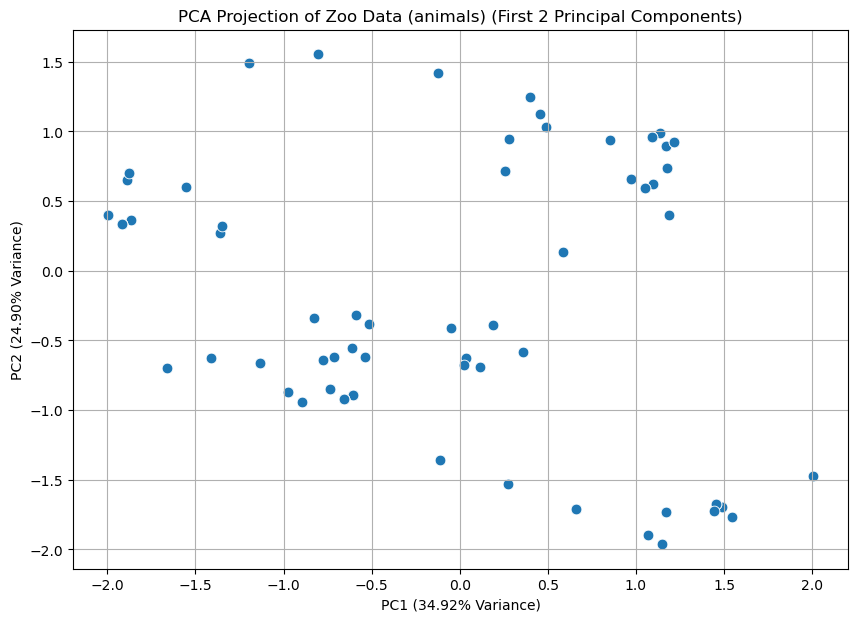

In [ ]:
# your code here
# Apply PCA -> reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0]:.2%}")
print(f"Variance explained by PC2: {explained_variance[1]:.2%}")

# Add PCA results to dataframe for plotting
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

# Plot PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=df, s=60)
plt.title('PCA Projection of Zoo Data (animals) (First 2 Principal Components)')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} Variance)')
plt.grid(True)

There appear to be several dense groupings of points, suggesting evidence of natural clusters. However, some points are more isolated, indicating they are either outliers or perhaps unique animal categories. The clusters do not form very obviously spherical shapes. This could complicate K-means as it assumes spherical clusters. Some clusters are more elongated which, as K-means relies on Euclidean distance, may not be optimally grouped and instead hint that a density-based clustering algorithm (such as DBSCAN) might perform better. The two components together capture about 60% of the variance, meaning that this visualization is informative but doesn't tell the full story. Clustering will occur on the full feature set not just the PCA-reduced dimensions which may cause different behavior.

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.3 - Determining Optimal $k$</b></div>
Implement and visualize two different methods for determining the optimal number of clusters:

1. Plot the inertia vs $k$ for $k \in \{2,3,\dots,20\}$
2. Plot the average silhouette score vs $k$ for the same range

Choose and justify your optimal k based on these metrics. Discuss any differences between what the metrics suggest and whether one seems more reliable for this dataset.

K = 19: Silhouette Score = 0.4202
K = 20: Silhouette Score = 0.4160
K = 4: Silhouette Score = 0.4115
K = 17: Silhouette Score = 0.4012
K = 5: Silhouette Score = 0.3991


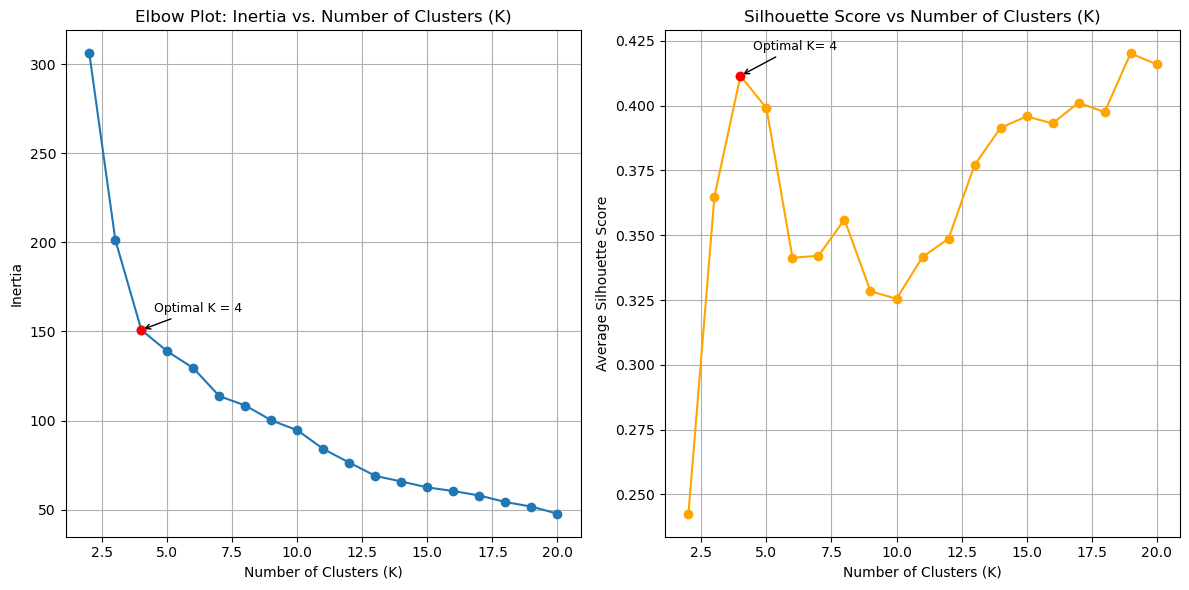

In [8]:
# your code here
# Range of k to test
k_vals = range(2, 21)
inertia, silhouette_scores = [], []

# Apply K-means for each k
for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)

    # Store inertia
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score and save it
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Sort k-values by silhouette score and display top 5
sorted_scores = sorted(zip(k_vals, silhouette_scores), key=lambda x: x[1], reverse=True)
for k, score in sorted_scores[:5]:
    print(f"K = {k}: Silhouette Score = {score:.4f}")

optimal_k = 4
idx_optimal_k = k_vals.index(optimal_k)
inertia_optimal = inertia[idx_optimal_k]
silhouette_optimal = silhouette_scores[idx_optimal_k]

# Plot inertia (Elbow method)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_vals, inertia, marker='o')
plt.title('Elbow Plot: Inertia vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.scatter(optimal_k, inertia_optimal, color='red', zorder=5)
plt.annotate(f'Optimal K = {optimal_k}', xy=(optimal_k, inertia_optimal), xytext=(optimal_k + 0.5, inertia_optimal + 10), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=9)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_vals, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.scatter(optimal_k, silhouette_optimal, color='red', zorder=5)
plt.annotate(f'Optimal K= {optimal_k}', xy=(optimal_k, silhouette_optimal), xytext=(optimal_k + 0.5, silhouette_optimal + 0.01), arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=9)

plt.tight_layout()

1. Elbow Plot: Based on the elbow plot, the elbow point occurs between $K=4$ and $K=6$, after which the decrease in inertia plateaus, indicating diminishing return from adding more clusters. Therefore, this plot suggests between 4 and 6 clusters.
2. Silhouette Score: The highest silhouette scores occur at very high values of $K$, specifically $K=19$ and $K=20$. However, the next best silhouette score, still achieving a score of 0.4115 is $K=4$, which indeed falls into the range of $K$ reached by the elbow plot. Silhouette scores range from -1 to 1 where higher values indicate better cluster separation (points are closer to their own cluster centroid than to other centroids).

Conclusion: Based on the elbow plot, the inertia starts leveling off between $K=4$ and $K=6$. This is the region beyond which the marginal gains in reducing within-cluster distances become small. While the highest silhouette scores appear at $K=19$ and $K=20$, those very large number of clusters create many small clusters. In practice, this will over-partition the data, making each cluster very pure and losing general structure in the dataset. Therefore, $K=4$ stands out as a better tradeoff as its near the elbow in the inertia plot and has the 3rd highest silhouette score (0.4115) indicating moderate cluster separation.

Differences: The elbow method is subjective as pinpointing the exact elbow point is done by inspection. The silhouette score method is more quantitative but may favor higher values of $K$ due to clusters getting smaller and therefore increasing the distance to other clusters.

For this dataset, a combination of both is most reliable as the elbow method prevents over-partitioning the data with a high $K$ and the silhouette score confirms that this selection of $K=4$ indeed gives a reasonable level of within-cluster similarity and inter-cluster dissimilarity.

<!-- BEGIN QUESTION -->
<div class='exercise'><b>Q0.4 - Cluster Analysis</b></div>

Using the results of fitting K-means with your choice of optimal $k$, create a visualization showing:
   - Your datapoints in the 2D PCA space
   - Points colored by cluster assignment
   - Each `animal_name` annotated on the plot near its corresponding point 

Finally, interpret your results:
   - How well-separated are your clusters?
   - Do the clusters align with biological classifications?
   - Do any points seem to have been assigned to the wrong cluster? You may not be able to tell from your plot alone and so you should investigate this issue using one of the metrics discussed in class.

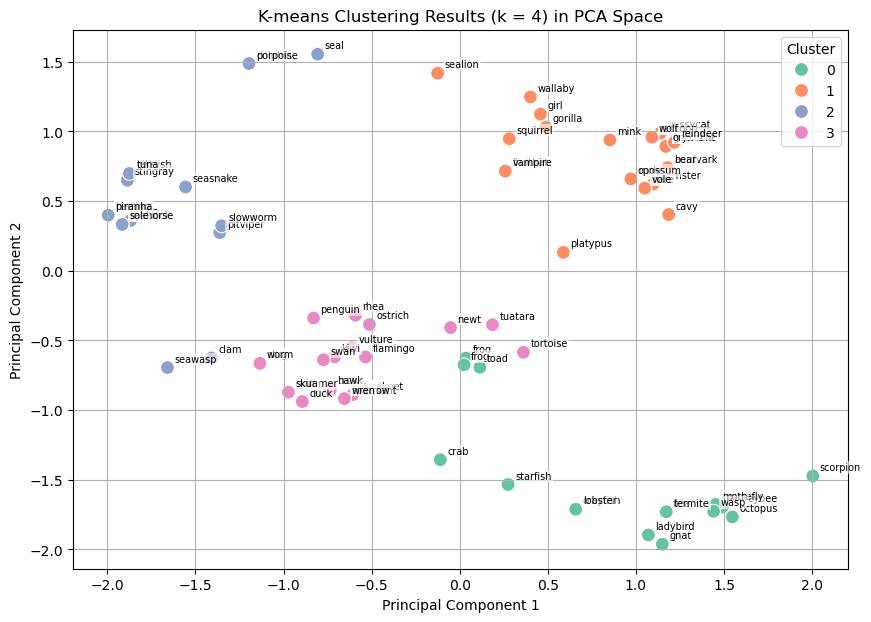

In [9]:
# your code here
# Fit K-means with k = 4
kmeans = KMeans(n_clusters=4, random_state=1)
df['cluster'] = kmeans.fit_predict(X)

# Plot PCA projection with cluster assignments
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df, palette='Set2', s=100, legend='full')

# Annotate each point with its animal_name
for i in range(df.shape[0]):
    plt.text(df['PC1'][i] + 0.04, df['PC2'][i] + 0.04, df['animal_name'][i], fontsize=7, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

plt.title('K-means Clustering Results (k = 4) in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)

In [10]:
# Calculate silhouette scores for each point
silhouette_vals = silhouette_samples(X, df['cluster'])
df['silhouette_score'] = silhouette_vals

# Display 5 points with lowest silhouette scores
misclassified = df[['animal_name', 'cluster', 'silhouette_score']].sort_values(by='silhouette_score').head()
print(misclassified)

   animal_name  cluster  silhouette_score
91     tuatara        3         -0.003108
52        newt        3          0.018847
13        clam        2          0.067565
89        toad        0          0.069210
81        slug        3          0.076056


1. How well-separated are your clusters?

Some clusters such as Cluster 1 and Cluster 2 are clearly well-separated as there seems to be a noticeable divide between `seal` and `sealion`. Other clusters show moderate overlap especially in the center of the plot such as Cluster 0 and Cluster 3. The overlap indicates that some animals share characteristics across clusters, which is expected given biological diversity.

2. Do the clusters align with biological classifications?

Cluster 0 seems to group invertebrates (e.g., octopus, scorpion, crab, starfish).

Cluster 1 seems to group mammals (e.g., gorilla, wolf, squirrel)

Cluster 2 seems to group aquatic animals (e.g., seal, stingray, piranha)

Cluster 3 seems to group both birds and reptiles... (e.g., penguin, vulture, tortoise)

3. Are any points assigned to the wrong cluster?

A silhouette score less than 0.1 is a sign of poor clustering quality. However, a *negative* silhouette score (like the one for tuatara) indicates that it may belong to a different cluster. This makes sense as Cluster 3 (to which it was assigned) seems to capture birds and reptiles. A tuatara is a reptile, possibly overlapping in traits with birds like egg-laying for example. It is reasonably close to Cluster 0 as well which captures invertebrates, which the tuatara could relate to due to properties such as it being aquatic.

In [11]:
# Additional imports for Parts 1-4
import arviz as az
import pymc as pm
from scipy.special import expit

## Hierarchical Bayesian Models

## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with datasets `train.csv` and `test.csv` which contain details of contraceptive usage among 1,934 Bangladeshi women.

There are four attributes for each woman along with a response variable, `contraceptive_use`, indicating if she uses contraceptives. The four attributes include:

* `district`: code identifying the district in which the woman lives (60 districts in total)
* `urban`: type of region of residence (binary)
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The task is to build a classification model that can predict if a given woman uses contraceptives.

The following cell will load and inspect the train and test datasets.

TRAINING DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 37.9 KB

TEST DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district           967 non-null    int64  
 1   urban              967 non-null    int64  
 2   living.children    967 non-null    int64  
 3   age_mean           967 non-null    float64
 4   contraceptive_use  967 non-null    int64  
dtypes: float64(1), int64(4)
m

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1


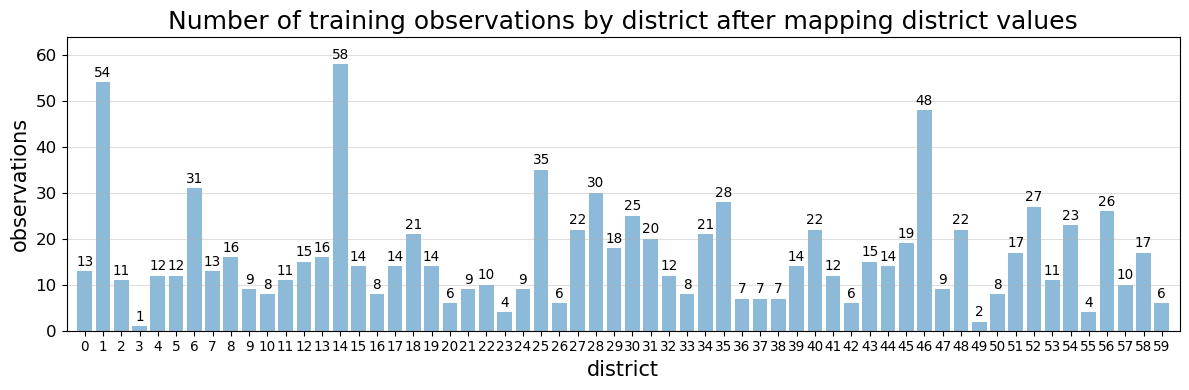

In [12]:
# loading and inspecting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# print dataset summary info for ease of reference
print("TRAINING DATA INFO:\n")
df_train.info()
print("\nTEST DATA INFO:\n")
df_test.info()
print("\nTRAINING DATA SUMMARY STATS:\n")
print(df_train.describe())
print("\nTRAINING DATA FIRST ROWS OF DATA:")
display(df_train.head(3))
print()

# And plot observation counts by district also just for reference
def plot_value_counts(value_counts, var_name, font_perc):
    """Generates barplot from pandas value_counts series"""
    fig, ax = plt.subplots(figsize=(12, 4))

    max_y = max(value_counts.values)
    n_cats = len(value_counts)

    ax.bar(range(n_cats), value_counts.values, alpha=0.5)

    for x, y in enumerate(value_counts):
        ax.text(
            x, y+max_y*.02,
            "{:,}".format(y),
            color="k",
            fontsize=14*font_perc,
            horizontalalignment="center"
        ) 

    ax.set_title(
        "Number of training observations by {} after mapping district values".format(
            var_name
        ),
        fontsize=18
    )
    ax.set_xlabel("{}".format(var_name), fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_xticks(range(n_cats))
    ax.set_xticklabels(value_counts.index)
    ax.tick_params("x", labelsize=14*font_perc)
    ax.tick_params("y", labelsize=12)
    ax.set_ylim(top=max_y+(max_y*.1))

    ax.grid(":", axis="y", alpha=0.4)
    ax.margins(x=.01)
    plt.tight_layout()
    plt.show();

# plot and print summary of resulting district values
dist_counts = df_train["district"].value_counts().sort_index()

plot_value_counts(dist_counts, "district", .7)



## Bayesian Logistic Regression with Varying-Intercept Description


The first model we'd like to fit to the contraceptives data will be a **varying-intercept logistic regression** model, where the model's intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part1"></a>

### <div class='exercise'>Part 1: Varying-Intercept Model (Simulated Response Variable)</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1 - Simulate Response</b></div>

To verify that PyMC can indeed recover the hidden parameter values, we'll simulate values of the response variable, `contraceptive_use`, for observations in the training set using the 4 predictors and *hard-coded model parameters of our choosing*. Then, using this simulated data, we'll check if PyMC can get back the parameter values that we hard-coded. If it does, we'll have some reason to believe that it can recover the hidden parameter values that generated the *real* data.

**Note: Synthetic response values generated using the parameters below will only be used in question 1.1 - 1.4**.

Generate $Y$ using the training data and the following hard-coded values:

$$
\begin{split}
\mu_0 &= 0.5
\\ \\
\sigma^2_0 &= 0.3
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 1
\\ \\ 
\beta_2 &= -0.5
\\ \\
\beta_3 &= -0.3
\\ \\
\end{split}
$$

Save your simulated values in a numpy array called `simulated_Y`.

**Verify that these parameters generate data in which an average of 48% to 50% of subjects use contraceptives.**

In [13]:
# set seed for consistency across runs
np.random.seed(109)
# your code here
# Params for sim
mu_0 = 0.5
sigma2_0 = 0.3
sigma_0 = np.sqrt(sigma2_0)
beta1 = 1.0
beta2 = -0.5
beta3 = -0.3

# Map each district to its index
districts = df_train['district'].unique()
n = len(districts)

# Draw one random intercept per district
beta0j = np.random.normal(loc=mu_0, scale=sigma_0, size=n)

# Create dictionary key: district, value: index in beta0j
district_index_map = {dist_val: idx for idx, dist_val in enumerate(sorted(districts))}

# For each row, find linear predictor
eta = []
for row in df_train.itertuples(index=False, name=None):
    # Row: district, urban, living.children, age_mean, contraceptive_use
    dist_val = row[0]
    dist_idx = district_index_map[dist_val]
    x_urban = row[1]
    x_children = row[2]
    x_age = row[3]

    eta_ij = (beta0j[dist_idx] + beta1 * x_urban + beta2 * x_children + beta3 * x_age)
    eta.append(eta_ij)

eta = np.array(eta)

# Convert linear predictor to probabilities and sample Bernoulli
p = 1.0 / (1.0 + np.exp(-eta))
simulated_Y = np.random.binomial(n=1, p=p)

# Check result
print(f"Percent of subjects that use contraceptives: {simulated_Y.mean() * 100:.2f}%")

Percent of subjects that use contraceptives: 49.12%


In [14]:
grader.check("q#1.1")

q#1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 - Fit Varying-Intercept Model (Simulated Data)</b></div>

Create and fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested by any warnings from PyMC.

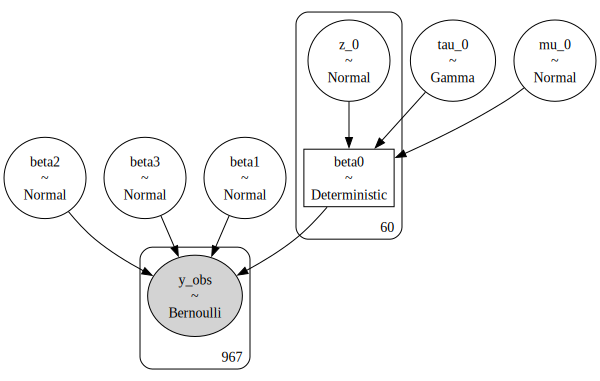

In [15]:
# your code here
with pm.Model() as varying_intercept_model:
    # Hyperpriors for district intercepts
    mu_0 = pm.Normal("mu_0", mu=0.0, sigma=100.0)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = 1.0 / np.sqrt(tau_0)

    # Non-centered random intercept for each district
    z_0 = pm.Normal("z_0", mu=0.0, sigma=1.0, shape=n)  
    beta0 = pm.Deterministic("beta0", mu_0 + z_0 * sigma_0)

    # Fixed effects
    beta1 = pm.Normal("beta1", mu=0.0, sigma=100.0)
    beta2 = pm.Normal("beta2", mu=0.0, sigma=100.0)
    beta3 = pm.Normal("beta3", mu=0.0, sigma=100.0)

    # Make linear predictor
    district_idx_series = df_train['district'].map(district_index_map).values
    x_urban = df_train['urban'].values
    x_children = df_train["living.children"].values
    x_age = df_train["age_mean"].values

    eta = beta0[district_idx_series] + beta1 * x_urban + beta2 * x_children + beta3 * x_age

    # Probability
    p = pm.math.sigmoid(eta)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p, observed=simulated_Y)

    # Visualize model structure
    display(pm.model_to_graphviz(varying_intercept_model))

In [16]:
# Sample from posterior
with varying_intercept_model:
    trace = pm.sample(draws=3000, tune=3000, target_accept=0.95, random_seed=109, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, z_0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 12 seconds.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3 - Convergence Diagnostics</b></div>

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged? Explain your reasoning.


**Hint:** Use the Arviz `plot_trace()` function

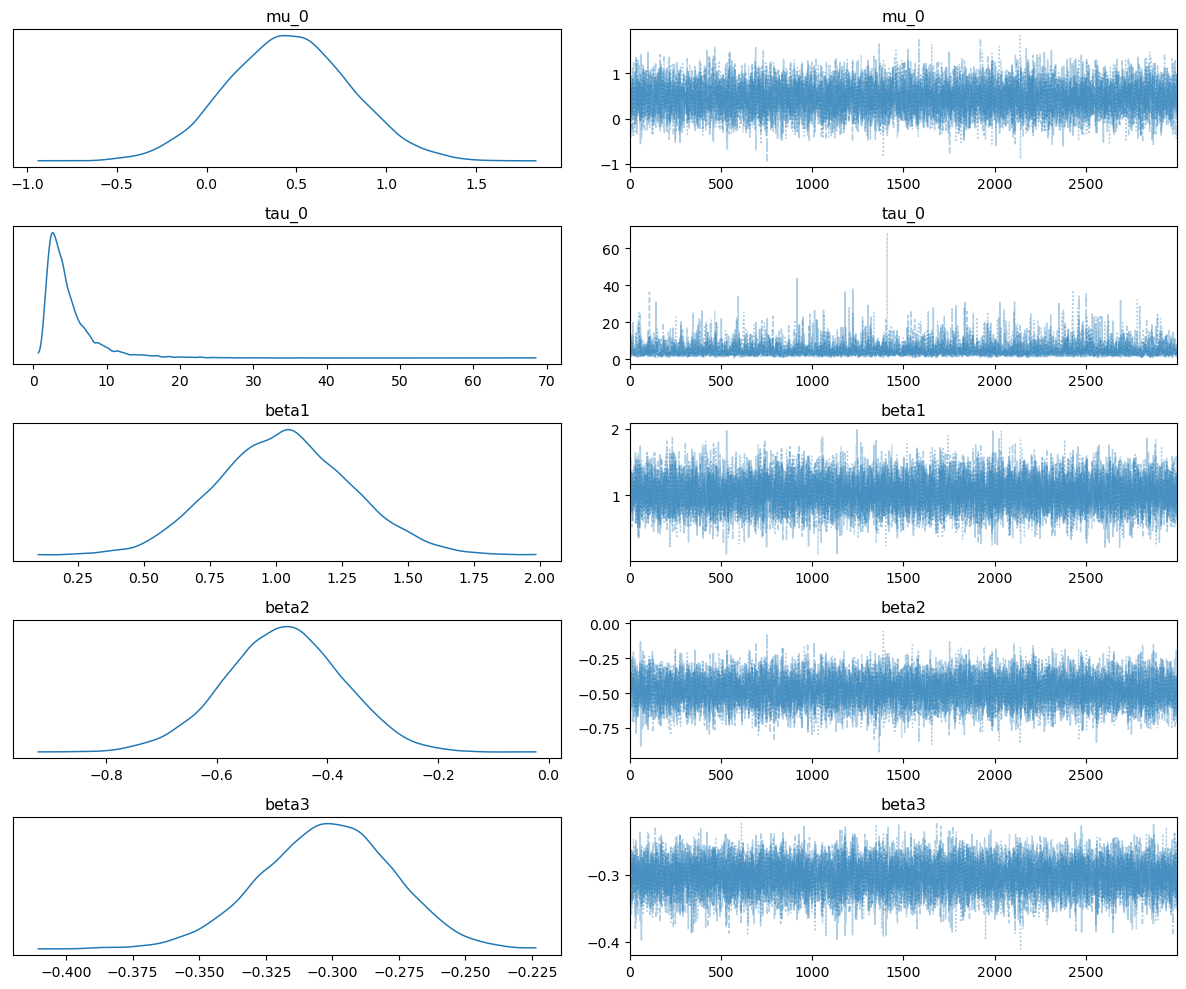

In [17]:
# your code here
with varying_intercept_model:
    az.plot_trace(
        trace,
        var_names=['mu_0', 'tau_0', 'beta1', 'beta2', 'beta3'],
        combined=True
    )
    plt.tight_layout()

In [18]:
# Inspect r-hat
stats = az.summary(trace, var_names=['mu_0', 'tau_0', 'beta1', 'beta2', 'beta3'])
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,0.455,0.341,-0.211,1.069,0.003,0.003,11280.0,8482.0,1.0
tau_0,4.811,3.655,0.910,10.887,0.045,0.032,5824.0,8876.0,1.0
beta1,1.031,0.253,0.576,1.519,0.002,0.001,15606.0,9711.0,1.0
beta2,-0.479,0.106,-0.682,-0.283,0.001,0.001,11931.0,8825.0,1.0
beta3,-0.302,0.025,-0.350,-0.257,0.000,0.000,14640.0,9695.0,1.0


From the trace plots and summary statistics, the r-hat values for all global parameters ($\mu_0, \tau_0, \beta_1, \beta_2, \beta_3$) are all 1.0, indicating that all chains mixed well and converged to the same posterior distribution. Additionally, the mean value of $\mu_0$ is 0.455 which is fairly close to the true 0.50, and the 94% HDI includes 0.50. Similarly, the same observation can be made for $\beta_1$, $\beta_2$, and $\beta_3$ which each had mean values 1.031, -0.479, and -0.302 respectively, being fairly close to their true values of 1.0, -0.50, and -0.30 respectively, and again, their 94% HDIs each capture their true values. $\tau_0$ was 4.811, indicating variation in district intercepts which is roughly consistent with a $\sigma_0$ of 0.45 as opposed to 0.54 which was the true value (this was derived as $\tau_0=\frac{1}{\sigma_0^2}$. Visualy, each chain's trace appears to explore within the same region without any chain getting stuck. The posterior marginal distributions look unimodal and stable, therefore, the sampler converged for these parameters.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4 - Inspecting Posteriors</b></div>

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

Intercept values used in simulation for these districts:

District 9 -> 0.041
District 19 -> 0.664
District 29 -> 0.059
District 39 -> 0.528
District 49 -> 0.386
District 59 -> 0.686


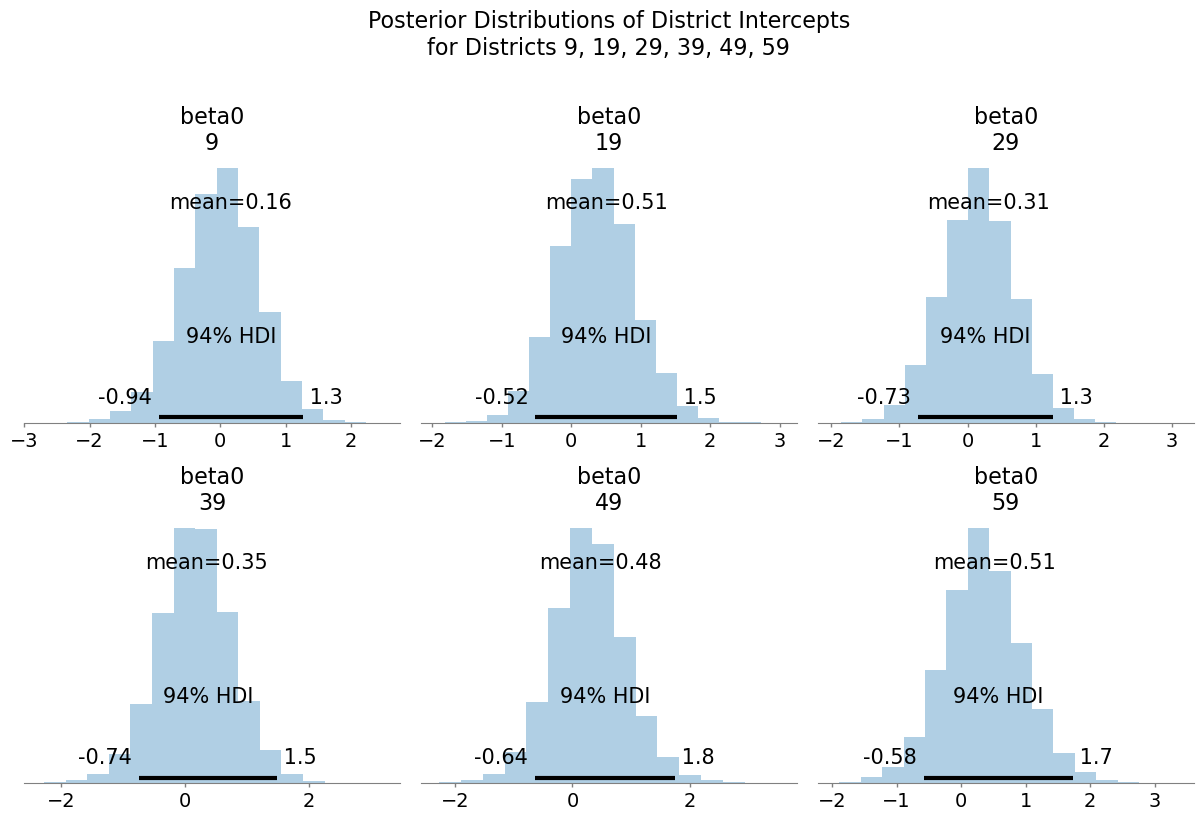

In [19]:
# your code here
key_districts = [9, 19, 29, 39, 49, 59]

print("Intercept values used in simulation for these districts:\n")
for d in key_districts:
    true = beta0j[d]
    print(f"District {d} -> {true:.3f}")

with varying_intercept_model:
    # Slice beta0 dimension
    az.plot_posterior(
        trace,
        var_names=['beta0'],
        coords={'beta0_dim_0': key_districts},
        figsize=(12, 8),
        kind='hist',
        point_estimate='mean',
        hdi_prob=0.94
    )

plt.suptitle("Posterior Distributions of District Intercepts\nfor Districts 9, 19, 29, 39, 49, 59", fontsize=16, y=1.02)
plt.tight_layout()

Picking six district intercepts (9, 19, 29, 39, 49, 59), the true $\beta_{0j}$ used in the simulation was compared to each district's posterior distribution. For each, the true value indeed does lie within the 94% highest-density interval for that district's intercept. For example, District 9 had a true intercept of 0.041 and its posterior distribution is centered around 0.16 with an HDI spanning $[-0.94, 1.3]$ and 0.041 is within that interval. Similarly, the same is true for the other five districts. Even though the posterior mean might differ from the exact simulation value, the true intercept is covered by each district's credible interval.

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

### <div class='exercise'>Part 2: Varying-Intercept Model (Real Data)</div> 

[Return to contents](#contents)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1 - Fit Varying-Intercept Model (Real Data)</b></div>

Now we'll fit our model to the *actual* data. Construct and fit the varying-intercept model to the real training data.

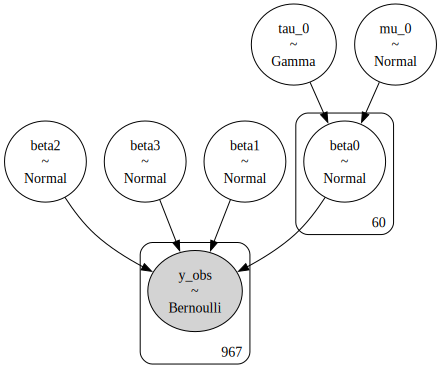

In [20]:
# your code here
with pm.Model() as varying_intercept_model_real:
    # Hyperpriors for district intercepts
    mu_0 = pm.Normal("mu_0", mu=0.0, sigma=100.0)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = 1.0 / np.sqrt(tau_0)

    # District intercepts: shape = # of districts
    beta0 = pm.Normal('beta0', mu=mu_0, sigma=sigma_0, shape=n)

    # Fixed effects
    beta1 = pm.Normal("beta1", mu=0.0, sigma=100.0)
    beta2 = pm.Normal("beta2", mu=0.0, sigma=100.0)
    beta3 = pm.Normal("beta3", mu=0.0, sigma=100.0)

    # Make linear predictor for each row
    district_idx_series = df_train["district"].map(district_index_map).values
    x_urban = df_train["urban"].values
    x_children = df_train["living.children"].values
    x_age = df_train["age_mean"].values

    eta = beta0[district_idx_series] + beta1*x_urban + beta2*x_children + beta3*x_age
    p = pm.math.sigmoid(eta)

    # Observed Bernoulli data
    y_obs = pm.Bernoulli("y_obs", p, observed=df_train["contraceptive_use"].values)

    # Visualize model structure
    display(pm.model_to_graphviz(varying_intercept_model_real))

In [21]:
with varying_intercept_model_real:
    # Sample from posterior
    trace_vi = pm.sample(draws=2000, tune=2000, target_accept=0.95, chains=4, random_seed=109)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta0, beta1, beta2, beta3]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2 - Convergence Diagnostics</b></div>

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

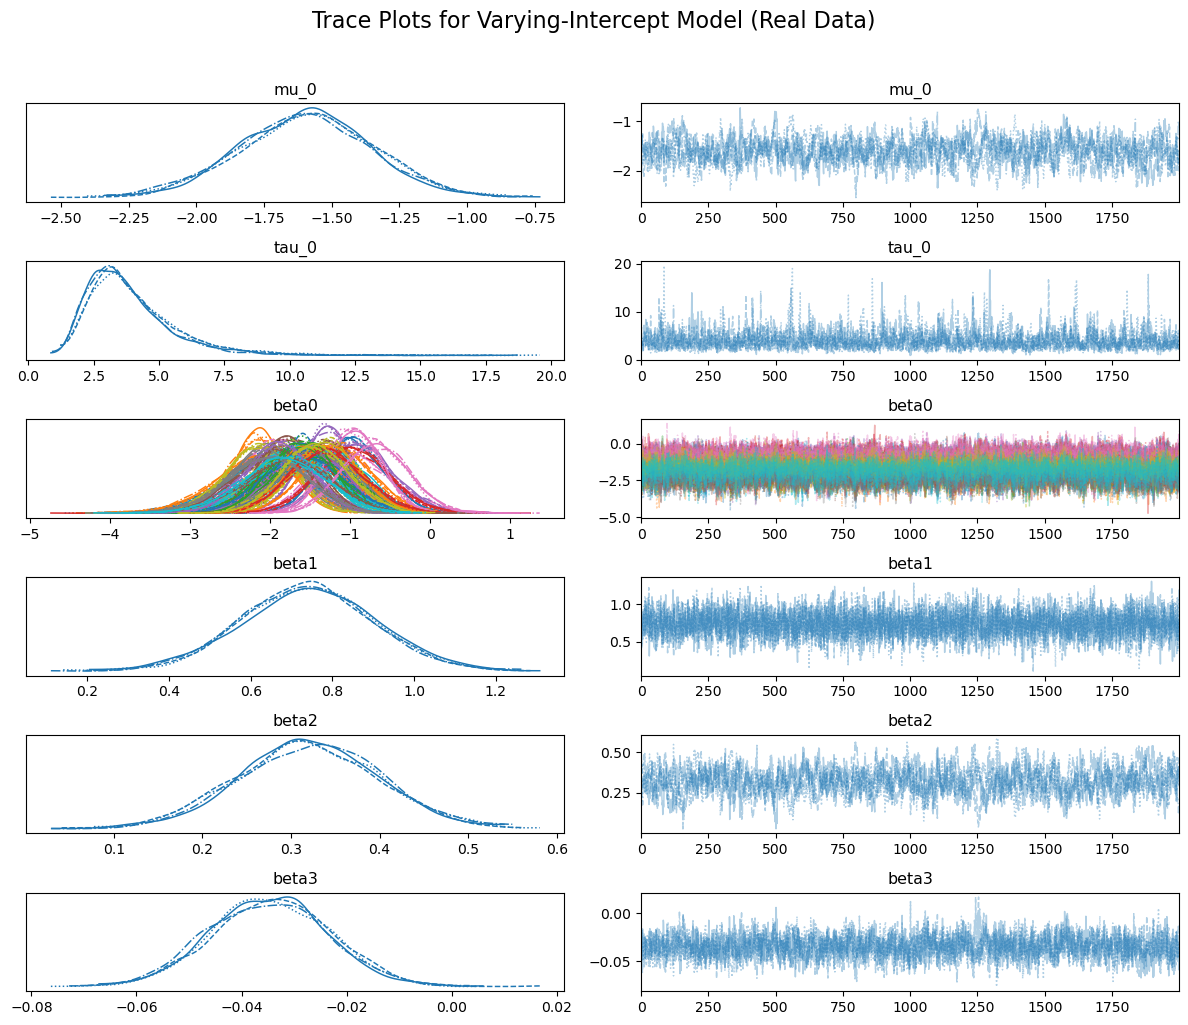

In [22]:
# your code here
# Trace plots
with varying_intercept_model_real:
    az.plot_trace(
        trace_vi,
        var_names=["mu_0","tau_0","beta0","beta1","beta2","beta3"],
        figsize=(12, 10)
    )
    plt.suptitle("Trace Plots for Varying-Intercept Model (Real Data)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [23]:
# Print r-hat, summary stats
summary_vi_real = az.summary(
    trace_vi,
    var_names=["mu_0","tau_0","beta0","beta1","beta2","beta3"]
)
summary_vi_real

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-1.595,0.247,-2.079,-1.144,0.011,0.008,532.0,895.0,1.00
tau_0,3.961,1.812,1.500,7.202,0.053,0.037,1239.0,2056.0,1.01
beta0[0],-2.067,0.491,-2.999,-1.154,0.012,0.008,1660.0,2764.0,1.00
beta0[1],-2.116,0.370,-2.830,-1.435,0.012,0.009,925.0,1825.0,1.00
beta0[2],-1.763,0.486,-2.692,-0.867,0.011,0.008,1807.0,3681.0,1.00
...,...,...,...,...,...,...,...,...,...
beta0[58],-1.431,0.426,-2.224,-0.610,0.011,0.008,1537.0,3704.0,1.00
beta0[59],-1.838,0.532,-2.835,-0.832,0.012,0.008,2005.0,4098.0,1.00
beta1,0.740,0.162,0.437,1.048,0.003,0.002,3402.0,4961.0,1.00
beta2,0.320,0.080,0.172,0.472,0.003,0.002,567.0,1004.0,1.00


The trace plots show that each chain for $\mu_0$, $\tau_0$, $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$ appears to explore the posterior without getting stuck. There do not appear to be divergences, and the r-hat values are all 1.0 or very close. These observations suggest that the sampler did indeed converge for the real data. The $\beta_0$ plot has multiple overlaid traces, one per district, and while each trace has its own range, none seem stuck in a corner of parameter space. Altogether, this indicates good mixing and stable chains.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3 - Districts with Highest & Lowest Rates of Contraceptive Usage</b></div>

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest? Explain how you arrived at these conclusions, interpreting any numerical values that played a role in your reasoning.

Highest intercept district: 56 with posterior mean -0.694
Lowest intercept district: 11 with posterior mean -2.184


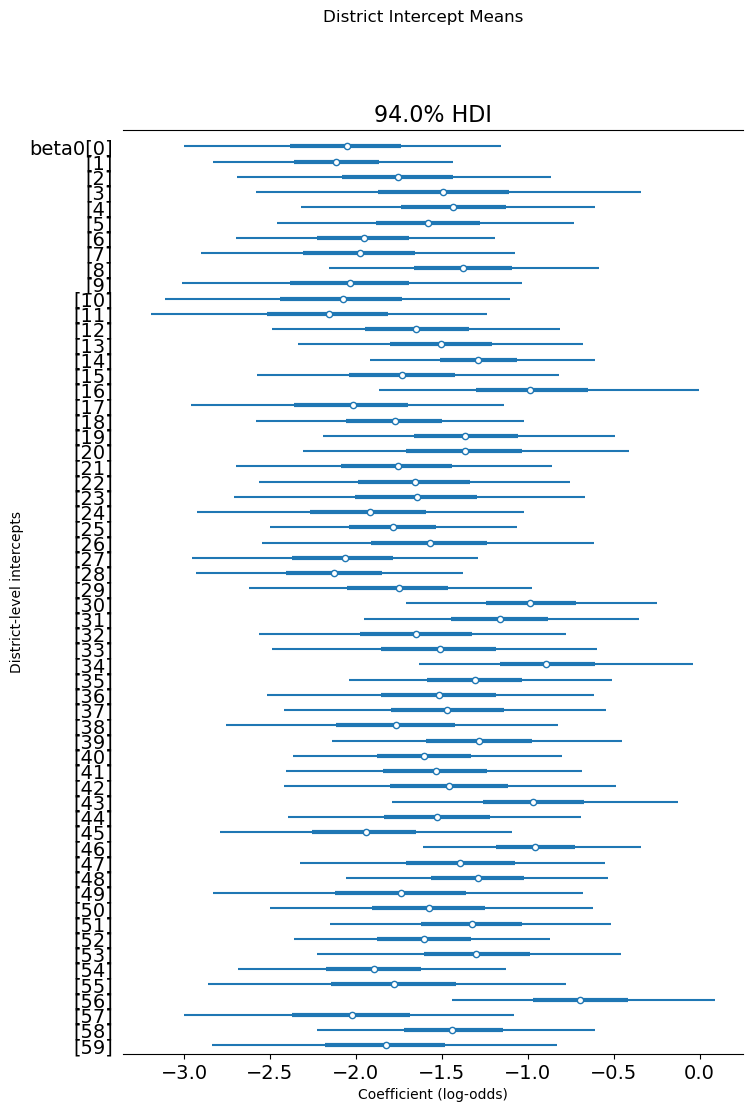

In [24]:
# your code here
# Single mean per district
beta0_means = trace_vi.posterior['beta0'].mean(dim=('chain', 'draw')).values

# Find district index with highest base rate
max_idx, min_idx = np.argmax(beta0_means), np.argmin(beta0_means)

# Convert index to district number
all_districts_sorted = sorted(df_train['district'].unique())
dist_with_max = all_districts_sorted[max_idx]
dist_with_min = all_districts_sorted[min_idx]

# Plot district intercept means
az.plot_forest(trace_vi, var_names=["beta0"], combined=True, hdi_prob=0.94, figsize=(8, 12))
plt.xlabel('Coefficient (log-odds)')
plt.ylabel('District-level intercepts')
plt.suptitle("District Intercept Means", fontsize=12)

print(f"Highest intercept district: {dist_with_max} with posterior mean {beta0_means[max_idx]:.3f}")
print(f"Lowest intercept district: {dist_with_min} with posterior mean {beta0_means[min_idx]:.3f}")

The district with the highest posterior mean for its intercept is District 56 with -0.694 and the lowest is District 11 with -2.184. Because these intercepts are on the log-odds scale, higher intercepts correspond to higher baseline probability of contraceptive use holding other predictors constant. To arrive at these conclusions, I calculated the posterior mean of each district's intercept $\beta_{0j}$ and sorted them from largest to smallest. The top one is the highest base rate and the bottom is the lowest base rate. Although both numbers are negative, -0.694 is much higher than -2.184 on the log-odds scale, thus, District 56 has much higher baseline usage probability than District 11.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4 - Varying Intercept? Conclusions from Posterior Samples</b></div>

What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts? Explain why or why not.


**Hint:** Both ArviZ's `plot_posterior` and [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) functions will prove useful here.

In [25]:
# your code here
# Get posterior means for mu_0 and sigma_0
mu0_mean = trace_vi.posterior['mu_0'].mean(dim=('chain', 'draw')).values
sigma0_samples = 1.0 / np.sqrt(trace_vi.posterior['tau_0'])
sigma0_mean = sigma0_samples.mean(dim=('chain', 'draw')).values

print(f"Posterior mean of mu_0 = {mu0_mean:.3f}")
print(f"Posterior mean of sigma_0 = {sigma0_mean:.3f}")
if sigma0_mean < 0.05:
    print("Small sigma_0 implies little variation across districts.")
else:
    print("Non-trivial sigma_0 supports a varying-intercept model.")

Posterior mean of mu_0 = -1.595
Posterior mean of sigma_0 = 0.535
Non-trivial sigma_0 supports a varying-intercept model.


Based on the output, $\mu_0 \approx -1.595$ which is the mean of the district intercepts, and $\sigma_0 \approx 0.535$ which is the standard deviation of the district intercepts around $\mu_0$. The results support the use of a varying-intercept model as: If $\sigma_0$ were close to 0, it would imply all districts share virtually the same intercept. That would suggest one could get away with a fixed-intercept model. However, $\sigma_0 = 0.535$ in reality, which is significantly greater than 0, indicating a meaningful variation between districts in baseline contraceptive usage (intercept).

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 3: Varying-Coefficient Model</div> 

[Return to contents](#contents)


The next model we will fit to the contraceptives data is a **varying-coefficients logistic regression** model. Here, in addition to a varying intercept, the coefficients on `living.children`, `age_mean`, and `urban` also vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:**

* The name "varying coefficient model" is used here to distinguish the Q3 model from the "varying intercept" model in Q2, but observe from the specification about that **BOTH** intercepts *and* coefficients vary in this Q3 model.
* Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 - Fit Varying Coefficient Model</b></div>

Fit the varying-coefficients model described above to the real training data.

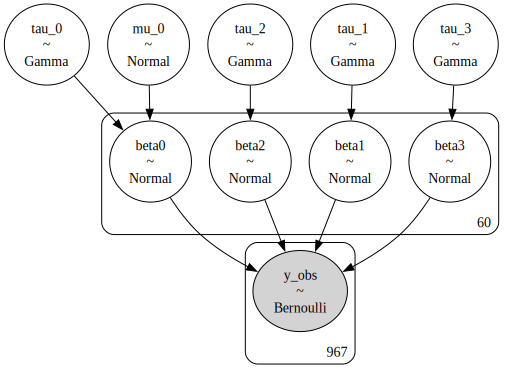

In [26]:
# your code here
with pm.Model() as varying_coeffs_model_real:
    
    # Hyperpriors for intercept
    mu_0 = pm.Normal("mu_0", mu=0.0, sigma=100.0)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = 1.0 / np.sqrt(tau_0)
    beta0 = pm.Normal("beta0", mu=mu_0, sigma=sigma_0, shape=n)

    # Hyperpriors for slope on urban
    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    sigma_1 = 1.0 / np.sqrt(tau_1)
    beta1 = pm.Normal("beta1", mu=0.0, sigma=sigma_1, shape=n)

    # Hyperpriors for slope on living.children
    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    sigma_2 = 1.0 / np.sqrt(tau_2)
    beta2 = pm.Normal("beta2", mu=0.0, sigma=sigma_2, shape=n)

    # Hyperpriors for slope on age_mean
    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    sigma_3 = 1.0 / np.sqrt(tau_3)
    beta3 = pm.Normal("beta3", mu=0.0, sigma=sigma_3, shape=n)

    # Construct linear predictor
    district_idx_series = df_train["district"].map(district_index_map).values
    x_urban = df_train["urban"].values
    x_children = df_train["living.children"].values
    x_age = df_train["age_mean"].values

    eta = (
        beta0[district_idx_series]
        + beta1[district_idx_series] * x_urban
        + beta2[district_idx_series] * x_children
        + beta3[district_idx_series] * x_age
    )
    p = pm.math.sigmoid(eta)

    # Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p, observed=df_train['contraceptive_use'].values)

    # Visualize model structure
    display(pm.model_to_graphviz(varying_coeffs_model_real))

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2 - Convergence Diagnostics</b></div>

Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the varying-intercept models earlier. What do you observe?

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, tau_0, beta0, tau_1, beta1, tau_2, beta2, tau_3, beta3]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 30 seconds.


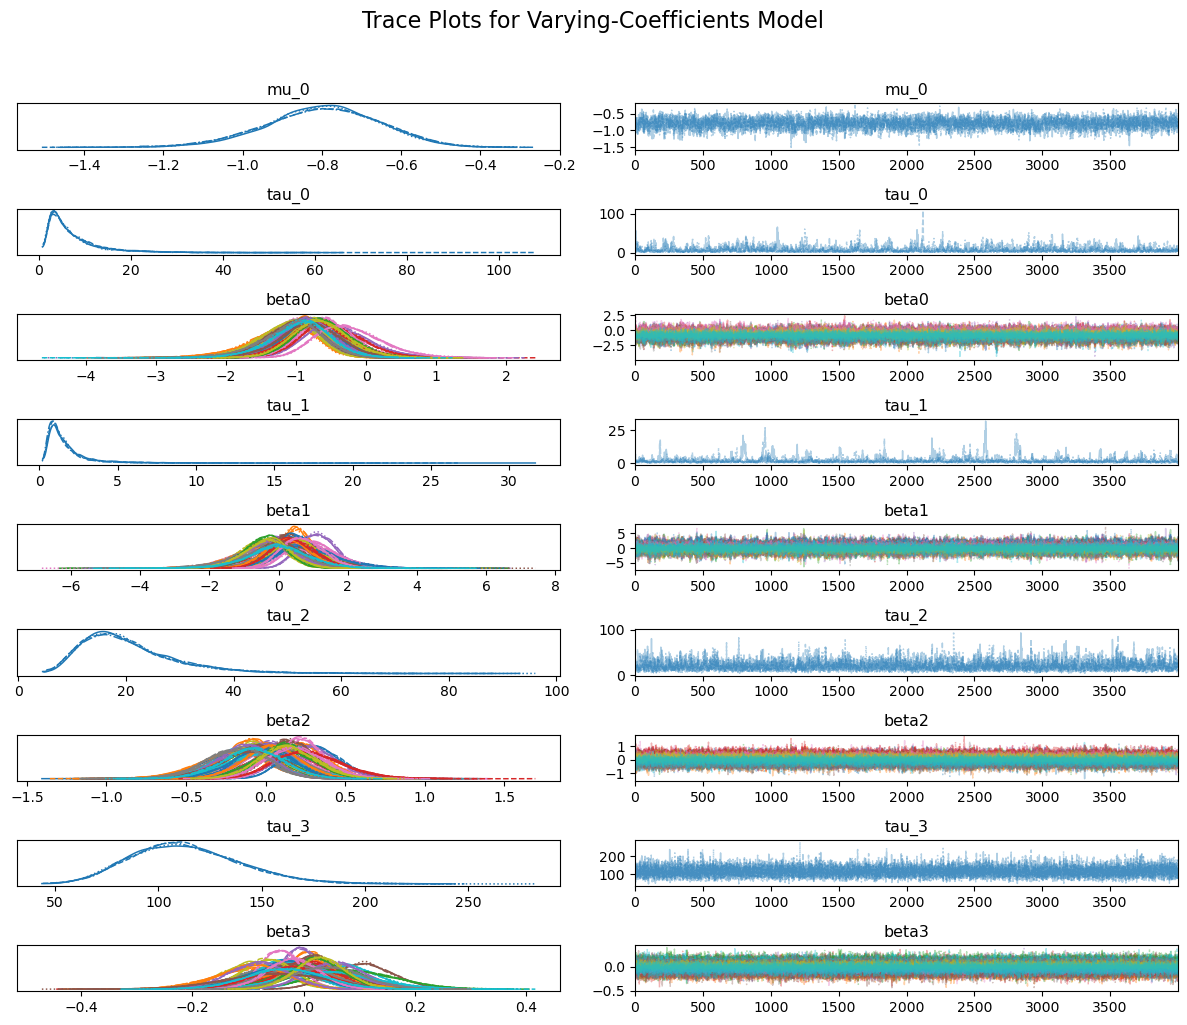

In [27]:
# your code here
with varying_coeffs_model_real:
    # Sample from posterior
    trace_vc = pm.sample(draws=4000, tune=4000, chains=4, target_accept=0.95, random_seed=109)

# Plot trace for global parameters and district-level parameters
with varying_coeffs_model_real:
    az.plot_trace(
        trace_vc,
        var_names=["mu_0", "tau_0", "beta0", "tau_1", "beta1", "tau_2", "beta2", "tau_3", "beta3"],
        figsize=(12, 10)
    )
    plt.suptitle("Trace Plots for Varying-Coefficients Model", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [28]:
# Inspect r-hat and summary stats
summary_vc_real = az.summary(
    trace_vc,
    var_names=["mu_0","tau_0","beta0","tau_1","beta1","tau_2","beta2","tau_3","beta3"],
)
summary_vc_real

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_0,-0.798,0.145,-1.059,-0.516,0.003,0.002,2696.0,4714.0,1.0
tau_0,7.353,6.327,1.056,18.500,0.197,0.139,892.0,2446.0,1.0
beta0[0],-1.041,0.443,-1.875,-0.216,0.006,0.004,7106.0,6627.0,1.0
beta0[1],-0.950,0.399,-1.737,-0.213,0.005,0.004,7819.0,7508.0,1.0
beta0[2],-0.877,0.431,-1.693,-0.042,0.004,0.003,12009.0,8266.0,1.0
...,...,...,...,...,...,...,...,...,...
beta3[55],-0.049,0.093,-0.217,0.128,0.001,0.001,26152.0,11414.0,1.0
beta3[56],-0.020,0.047,-0.105,0.072,0.000,0.000,18234.0,12225.0,1.0
beta3[57],0.042,0.064,-0.085,0.158,0.000,0.000,21788.0,12040.0,1.0
beta3[58],0.031,0.046,-0.056,0.118,0.000,0.000,22318.0,11908.0,1.0


From the trace plots, all parameters appear to have mixed well across the four chains. No single chain seems stuck and there are no signs of non-stationarity. All r-hat scores are 1.0 and no divergences were reported, hence, the sampler has converged well. The effective sample sizes are likely high enough to trust that the chains have thoroughly explored the posterior. Therefore, these inferences about district intercepts and slopes are reliable.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3 - Distribution of Posterior Means & HDIs</b></div>

Plot the distributions of posterior means and the 95% highest posterior density intervals (HDIs) for the intercepts and coefficients for each district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

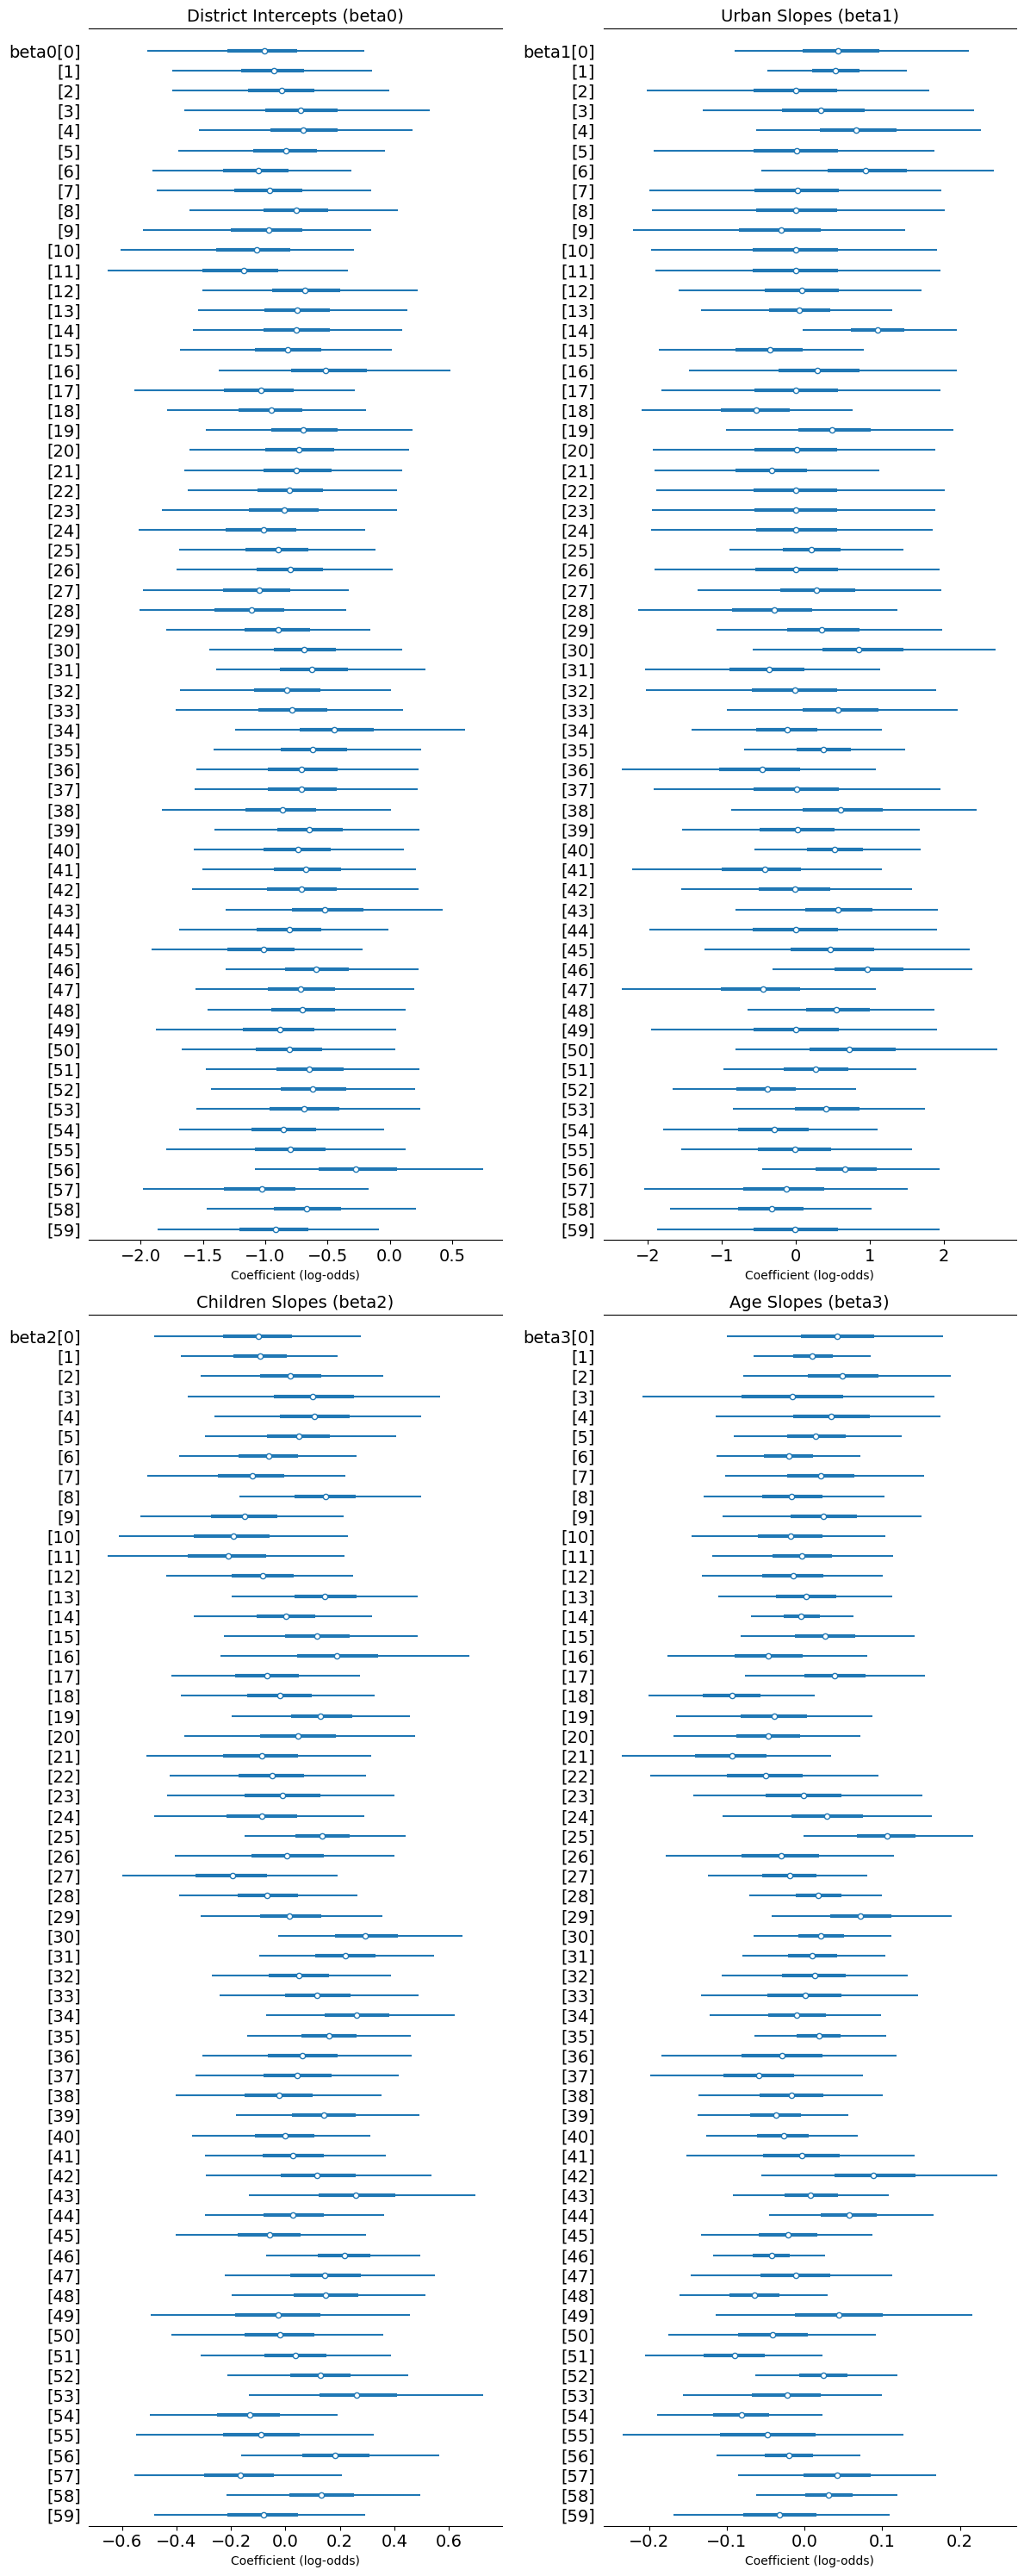

In [29]:
# your code here
param_list = ["beta0", "beta1", "beta2", "beta3"]
titles = [
    "District Intercepts (beta0)",
    "Urban Slopes (beta1)",
    "Children Slopes (beta2)",
    "Age Slopes (beta3)",
]
fig, axs = plt.subplots(2, 2, figsize=(12, 30))

for i, param in enumerate(param_list):
    row, col = divmod(i, 2)
    ax = axs[row, col]

    az.plot_forest(
        trace_vc,
        var_names=[param],
        combined=True,
        hdi_prob=0.95,
        kind="forestplot",
        ax=ax
    )
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Coefficient (log-odds)")
plt.tight_layout()

The intercepts (beta0) vary substantially. Some districts have negative intercepts well below -3 (meaning very low baseline probability of using contraceptives, holding all other predictors constant), whereas others are near 1-2 (implying high baseline probability). The urban slope (beta1) is often positive but exhibits meaningful district-to-district variation. This suggests urban is generally associated with increased contraceptive use. The children slope (beta2) might be negative for some districts (implying having more children reduces the log-odds of further contraceptive use) but less so or even near zero in others. The age slope (beta3) also varies, but much less. Some districts appear to have moderate positive or negative effect, while many are clustered near zero. The forest plot supports the idea that there is heterogeneity in intercepts and slopes across districts, justifying the full varying-coefficients approach rather than assuming a single global slope for each predictor.

<a id="part4"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

## <div class='exercise'>Part 4: Predictions & Model Selection</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1 - Model Evaluation & Comparison</b></div>

Now that we’ve fit varying-intercept and varying-coefficient models we will evaluate their predictive performance and compare them to a naive baseline.
 
First, sample from the posterior predictive distribution using `pm.sample_posterior_predictive()`, generating predictions for both models on the train and test sets.

Next, compute the accuracy and percentage of predictions classified as `1` for each model on both train and test.

Finally, compute the train and test accuracy of a naive model that predicts the most common class in the training set for all inputs.

In [30]:
# your code here
# 1) Posterior Predictive on TRAIN
with varying_intercept_model_real:
    ppc_train_vi = pm.sample_posterior_predictive(
        trace_vi,
        var_names=["y_obs"],  # matches the name of your Bernoulli node
        random_seed=109,
        return_inferencedata=False
    )

# 2) Posterior Predictive on TEST 
with pm.Model() as varying_intercept_model_test:
    mu_0 = pm.Normal("mu_0", 0, 100)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = 1.0 / np.sqrt(tau_0)
    beta0 = pm.Normal("beta0", mu=mu_0, sigma=sigma_0, shape=n)

    beta1 = pm.Normal("beta1", 0, 100)
    beta2 = pm.Normal("beta2", 0, 100)
    beta3 = pm.Normal("beta3", 0, 100)

    district_idx_test = df_test["district"].map(district_index_map).values
    x_urban_test = df_test["urban"].values
    x_children_test = df_test["living.children"].values
    x_age_test = df_test["age_mean"].values
    
    eta_test = beta0[district_idx_test] + beta1*x_urban_test + beta2*x_children_test + beta3*x_age_test
    p_test = pm.math.sigmoid(eta_test)
    
    y_test_pred = pm.Bernoulli("y_test_pred", p_test)

with varying_intercept_model_test:
    ppc_test_vi = pm.sample_posterior_predictive(
        trace_vi,
        var_names=["y_test_pred"],
        random_seed=109,
        return_inferencedata=False
    )

# 3) Convert draws -> 0/1 predictions by majority vote
preds_train_vi = (ppc_train_vi["y_obs"].mean(axis=0) >= 0.5)
preds_test_vi  = (ppc_test_vi["y_test_pred"].mean(axis=0) >= 0.5)

# 4) Evaluate accuracy
y_train_true = df_train["contraceptive_use"].values
y_test_true  = df_test["contraceptive_use"].values

acc_train_vi = (preds_train_vi == y_train_true).mean()
acc_test_vi  = (preds_test_vi  == y_test_true).mean()
pct_pred_ones_train_vi = preds_train_vi.mean()
pct_pred_ones_test_vi  = preds_test_vi.mean()

print("Varying-Intercept Model")
print(f"Train Accuracy = {acc_train_vi:.3f}")
print(f"Test Accuracy  = {acc_test_vi:.3f}")
print(f"% Predicted '1' on Train = {pct_pred_ones_train_vi*100:.1f}%")
print(f"% Predicted '1' on Test  = {pct_pred_ones_test_vi*100:.1f}%\n")


Sampling: [y_obs]


Output()

Sampling: [y_test_pred]


Output()

Varying-Intercept Model
Train Accuracy = 0.575
Test Accuracy  = 0.557
% Predicted '1' on Train = 49.6%
% Predicted '1' on Test  = 49.2%



In [31]:
# your code here
# 1) Posterior Predictive on TRAIN
with varying_coeffs_model_real:
    ppc_train_vc = pm.sample_posterior_predictive(
        trace_vc,
        var_names=["y_obs"],
        random_seed=109,
        return_inferencedata=False
    )

# 2) Posterior Predictive on TEST
with pm.Model() as varying_coeffs_model_test:
    mu_0 = pm.Normal("mu_0", 0, 100)
    tau_0 = pm.Gamma("tau_0", alpha=0.1, beta=0.1)
    sigma_0 = 1.0 / np.sqrt(tau_0)
    beta0 = pm.Normal("beta0", mu=mu_0, sigma=sigma_0, shape=n)

    tau_1 = pm.Gamma("tau_1", alpha=0.1, beta=0.1)
    sigma_1 = 1.0 / np.sqrt(tau_1)
    beta1 = pm.Normal("beta1", 0.0, sigma_1, shape=n)

    tau_2 = pm.Gamma("tau_2", alpha=0.1, beta=0.1)
    sigma_2 = 1.0 / np.sqrt(tau_2)
    beta2 = pm.Normal("beta2", 0.0, sigma_2, shape=n)

    tau_3 = pm.Gamma("tau_3", alpha=0.1, beta=0.1)
    sigma_3 = 1.0 / np.sqrt(tau_3)
    beta3 = pm.Normal("beta3", 0.0, sigma_3, shape=n)
    
    district_idx_test = df_test["district"].map(district_index_map).values
    x_urban_test = df_test["urban"].values
    x_children_test = df_test["living.children"].values
    x_age_test = df_test["age_mean"].values

    eta_test = (
        beta0[district_idx_test]
        + beta1[district_idx_test]*x_urban_test
        + beta2[district_idx_test]*x_children_test
        + beta3[district_idx_test]*x_age_test
    )
    p_test = pm.math.sigmoid(eta_test)

    y_test_pred = pm.Bernoulli("y_test_pred", p_test)

with varying_coeffs_model_test:
    ppc_test_vc = pm.sample_posterior_predictive(
        trace_vc,
        var_names=["y_test_pred"],
        random_seed=109,
        return_inferencedata=False
    )

# Convert draws -> 0/1
preds_train_vc = (ppc_train_vc["y_obs"].mean(axis=0) >= 0.5)
preds_test_vc  = (ppc_test_vc["y_test_pred"].mean(axis=0) >= 0.5)

# Evaluate accuracy
acc_train_vc = (preds_train_vc == y_train_true).mean()
acc_test_vc  = (preds_test_vc  == y_test_true).mean()
pct_pred_ones_train_vc = preds_train_vc.mean()
pct_pred_ones_test_vc  = preds_test_vc.mean()

print("Varying-Coefficient Model")
print(f"Train Accuracy = {acc_train_vc:.3f}")
print(f"Test Accuracy  = {acc_test_vc:.3f}")
print(f"% Predicted '1' on Train = {pct_pred_ones_train_vc*100:.1f}%")
print(f"% Predicted '1' on Test  = {pct_pred_ones_test_vc*100:.1f}%\n")


Sampling: [y_obs]


Output()

Sampling: [y_test_pred]


Output()

Varying-Coefficient Model
Train Accuracy = 0.608
Test Accuracy  = 0.545
% Predicted '1' on Train = 49.4%
% Predicted '1' on Test  = 49.6%



In [32]:
# your code here
# Naive model: always predict the majority class from TRAIN data
train_mean = y_train_true.mean()
naive_label = 1 if train_mean >= 0.5 else 0

preds_train_naive = np.full_like(y_train_true, naive_label)
preds_test_naive  = np.full_like(y_test_true,  naive_label)

acc_train_naive = (preds_train_naive == y_train_true).mean()
acc_test_naive  = (preds_test_naive  == y_test_true).mean()

print("Naive Baseline")
print(f"Train Accuracy = {acc_train_naive:.3f}")
print(f"Test Accuracy  = {acc_test_naive:.3f}")
print(f"% Predicted '1' on Train = {preds_train_naive.mean()*100:.1f}%")
print(f"% Predicted '1' on Test  = {preds_test_naive.mean()*100:.1f}%")

Naive Baseline
Train Accuracy = 0.610
Test Accuracy  = 0.605
% Predicted '1' on Train = 0.0%
% Predicted '1' on Test  = 0.0%


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2 - Model Selection</b></div>

What do you conclude from the results of 4.1? Which model appears to be the best (i.e. varying-intercept, varying-coefficient, or naive), and what is your rationale?

The naive baseline outperforms both hierarchical models on the test set. One explanation is class imbalance: if the data is skewed toward 0, always predicting 0 can give decent accuracy. The baseline 60.5% test accuracy suggests that ~60% of the test samples were actually 0. Another explanation could be that the hierarchical models overfit the training set. The varying-coefficient model does have higher training accuracy (0.608) but lower test accuracy (0.545) which typically points to overfitting. Another explanation could be if the features only weakly separate classes, then more flexible models could struggle to generalize, leading to worse performance in the hierarchical models. Based on these factors, the naive baseline appears to be the best in terms of raw test accuracy and avoiding overfitting as its train and test accuracies are quite similar.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `time_spent_on_hw`

In [33]:
time_spent_on_hw = 6.0

I found Parts 2 and 3 the most challenging. In particular, I struggled with the hierarchical model notation, ensuring that each district's intercept and slope was accounted for. I also had difficulty debugging PyMC code and had to frequently reference the documentation to clarify model specs, shapes, and arguments.

In [34]:
grader.check("q4.3")

q4.3 results: All test cases passed!

In [35]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 1.14 minutes for this notebook to run


**This concludes HW1. Thank you!** 🌈